API demo to detect the objective images that stored in S3 bucket. 

In [1]:
import boto3
import cv2
import numpy as np
import pandas as pd
import json
import boto3
import requests
import cv2
import sagemaker
import matplotlib.pyplot as plt
from sagemaker.tensorflow.model import TensorFlowModel 
import requests 
import pymysql
from sqlalchemy import create_engine
from sqlalchemy import event
import pandas.io.sql as psql


bucket='dash-datapipeline' 

def load_image(s3key):
    s3 = boto3.resource('s3')
    myobject = s3.Object(bucket,s3key)
    content=myobject.get()['Body'].read()
    nparr = np.frombuffer(content, np.uint8)
    img_np = cv2.imdecode(nparr, cv2.IMREAD_COLOR) 
    width = 300
    height = int(300*(img_np.shape[0]/img_np.shape[1]))
    dim = (width, height)
    
    # resize imag and change BGR to RGB
    resized = cv2.resize(img_np, dim, interpolation = cv2.INTER_AREA)
    RGB_img = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show() 
    image_np_expanded=np.expand_dims(RGB_img, axis=0)
    return image_np_expanded 

def predict_cocacola(s3key):
    session = boto3.session.Session(region_name='eu-west-2')
    sagemaker_session = sagemaker.Session(boto_session=session)
    np_array=load_image(s3key)
    endpoint_name='sagemaker-tensorflow-2019-05-30-11-36-29-809'
    predictor=sagemaker.tensorflow.model.TensorFlowPredictor(endpoint_name, sagemaker_session)
    result=predictor.predict(np_array)
    brand=result['outputs']['detection_classes']['float_val'][0]
    score=result['outputs']['detection_scores']['float_val'][0]
    if brand==1:
        return {'brand':'coca-cola','probability':score}
    else:
        return {'brand':'pepsi','probability':score} 


def predict_cocacola_url(url):
    r=requests.get(url)
    if r.status_code!=200:
        raise Exception('requests error,status_code:{}'.format(r.status_code))
        
    content=r.content
    session = boto3.session.Session(region_name='eu-west-2')
    sagemaker_session = sagemaker.Session(boto_session=session)
    nparr = np.frombuffer(content, np.uint8)
    img_np = cv2.imdecode(nparr, cv2.IMREAD_COLOR) 
    width = 300
    height = int(300*(img_np.shape[0]/img_np.shape[1]))
    dim = (width, height) # resize image
    
    resized = cv2.resize(img_np, dim, interpolation = cv2.INTER_AREA)
    RGB_img = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.axis('off') 
    plt.show() 
    
    image_np_expanded=np.expand_dims(RGB_img, axis=0) 
    #deploy a new api endpoint in the sagemaker 
    endpoint_name='sagemaker-tensorflow-2019-05-30-11-36-29-809'
    predictor=sagemaker.tensorflow.model.TensorFlowPredictor(endpoint_name, sagemaker_session)
    result=predictor.predict(image_np_expanded)
    brand=result['outputs']['detection_classes']['float_val'][0]
    score=result['outputs']['detection_scores']['float_val'][0]
    if brand==1:
        return {'brand':'coca-cola','probability':score}
    else:
        return {'brand':'pepsi','probability':score}  
    

#mock database
host="rds-mysql-aunz.cn8zi5k8bzi2.us-east-1.rds.amazonaws.com"
user="aunz"
passwd="dFNxP87chRwb"
db='DataCenter'
engine = create_engine("mysql+pymysql://"+user+':'+passwd+"@"+host+"/"+db+'?charset=utf8mb4') 

qry = '''SELECT * FROM DataCenter.meal_image; '''

meal_img= psql.read_sql(qry,engine) 
print(meal_img.shape) 
meal_img[:10]

(247666, 7)


,id_source,image_url,source,s3key,bucketname,last_refresh,created_at
0,00032d28-6f94-311f-8779-448d7c43aa56,http://f.roocdn.com/images/menu_items/10846441...,deliveroo,food_image/deliveroo/00032d28-6f94-311f-8779-4...,dash-datapipeline,2019-05-27 03:12:37,2019-05-27 03:12:37
1,00032d28-6f94-311f-8779-448d7c43aa56,http://f.roocdn.com/images/menu_items/10847185...,deliveroo,food_image/deliveroo/00032d28-6f94-311f-8779-4...,dash-datapipeline,2019-05-27 03:12:41,2019-05-27 03:12:41
2,00032d28-6f94-311f-8779-448d7c43aa56,http://f.roocdn.com/images/menu_items/10846435...,deliveroo,food_image/deliveroo/00032d28-6f94-311f-8779-4...,dash-datapipeline,2019-05-27 03:12:38,2019-05-27 03:12:38
3,00032d28-6f94-311f-8779-448d7c43aa56,http://f.roocdn.com/images/menu_items/10846986...,deliveroo,food_image/deliveroo/00032d28-6f94-311f-8779-4...,dash-datapipeline,2019-05-27 03:12:37,2019-05-27 03:12:37
4,00032d28-6f94-311f-8779-448d7c43aa56,http://f.roocdn.com/images/menu_items/10846555...,deliveroo,food_image/deliveroo/00032d28-6f94-311f-8779-4...,dash-datapipeline,2019-05-27 03:12:39,2019-05-27 03:12:39
5,00032d28-6f94-311f-8779-448d7c43aa56,http://f.roocdn.com/images/menu_items/10846343...,deliveroo,food_image/deliveroo/00032d28-6f94-311f-8779-4...,dash-datapipeline,2019-05-27 03:12:38,2019-05-27 03:12:38
6,000e2857-cd99-3a95-960c-8f502f6f7ae2,http://f.roocdn.com/images/menu_items/6280892/...,deliveroo,food_image/deliveroo/000e2857-cd99-3a95-960c-8...,dash-datapipeline,2019-05-27 03:12:42,2019-05-27 03:12:42
7,000e2857-cd99-3a95-960c-8f502f6f7ae2,http://f.roocdn.com/images/menu_items/6280843/...,deliveroo,food_image/deliveroo/000e2857-cd99-3a95-960c-8...,dash-datapipeline,2019-05-27 03:12:34,2019-05-27 03:12:34
8,000e2857-cd99-3a95-960c-8f502f6f7ae2,http://f.roocdn.com/images/menu_items/6280873/...,deliveroo,food_image/deliveroo/000e2857-cd99-3a95-960c-8...,dash-datapipeline,2019-05-27 03:12:41,2019-05-27 03:12:41
9,000e2857-cd99-3a95-960c-8f502f6f7ae2,http://f.roocdn.com/images/menu_items/6280864/...,deliveroo,food_image/deliveroo/000e2857-cd99-3a95-960c-8...,dash-datapipeline,2019-05-27 03:12:41,2019-05-27 03:12:41


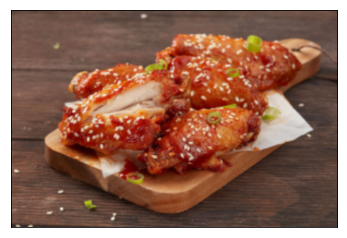

{'brand': 'coca-cola', 'probability': 0.0012340318644419312}


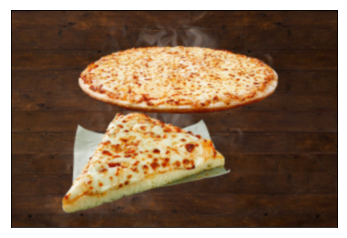

{'brand': 'coca-cola', 'probability': 0.0010644737631082535}


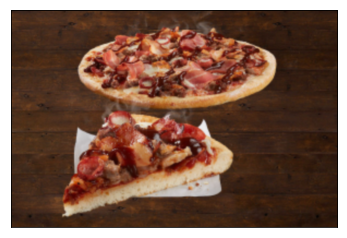

{'brand': 'coca-cola', 'probability': 0.003744589863345027}


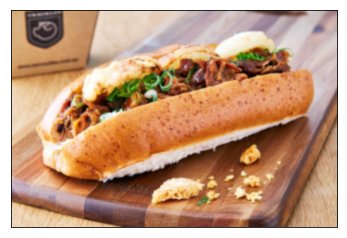

{'brand': 'coca-cola', 'probability': 0.0007248343899846077}


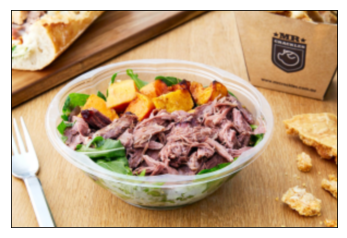

{'brand': 'coca-cola', 'probability': 0.001704607275314629}


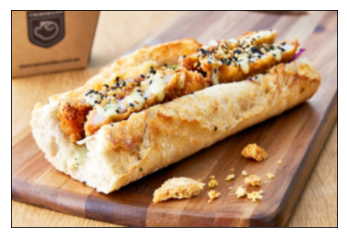

{'brand': 'coca-cola', 'probability': 0.0016984384274110198}


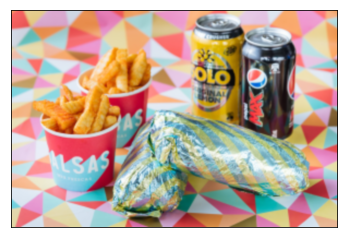

{'brand': 'coca-cola', 'probability': 0.02906683273613453}


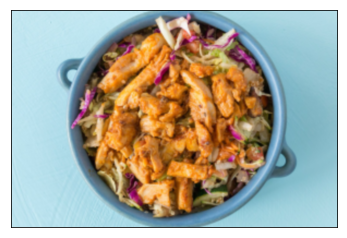

{'brand': 'pepsi', 'probability': 0.007578807882964611}


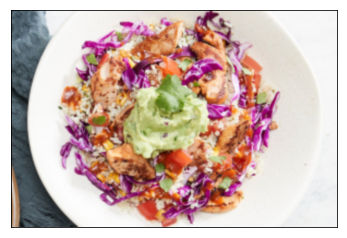

{'brand': 'coca-cola', 'probability': 0.0009557988378219306}


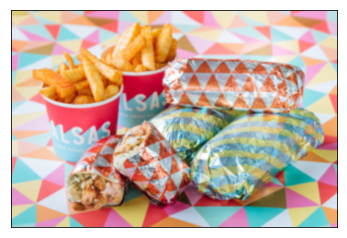

{'brand': 'coca-cola', 'probability': 0.013027839362621307}


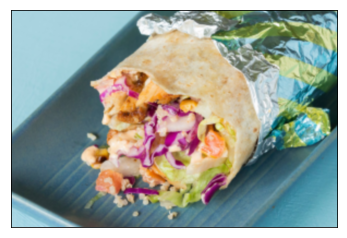

{'brand': 'pepsi', 'probability': 0.0014750093687325716}


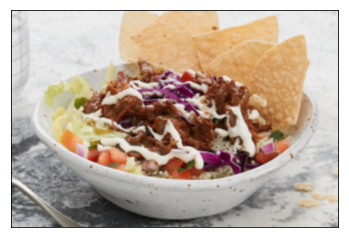

{'brand': 'coca-cola', 'probability': 0.0011544906301423907}


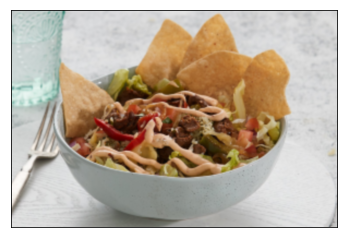

{'brand': 'pepsi', 'probability': 0.0020397233311086893}


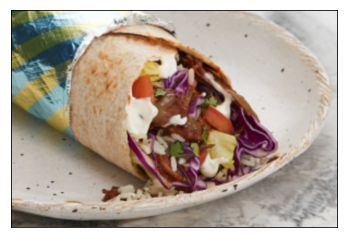

{'brand': 'coca-cola', 'probability': 0.0012121968902647495}


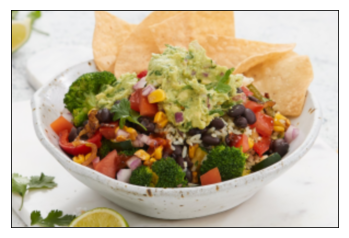

{'brand': 'coca-cola', 'probability': 0.0007276428514160216}


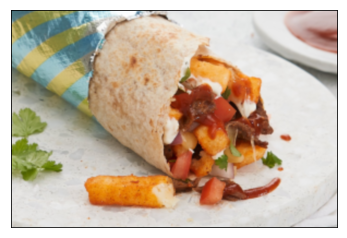

{'brand': 'pepsi', 'probability': 0.000921301485504955}


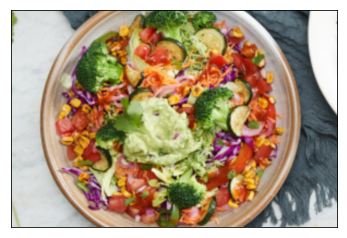

{'brand': 'pepsi', 'probability': 0.002627523150295019}


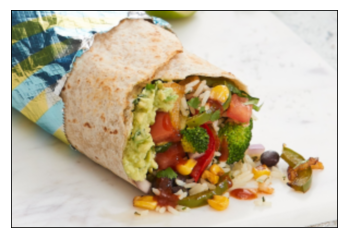

{'brand': 'pepsi', 'probability': 0.0010014723520725965}


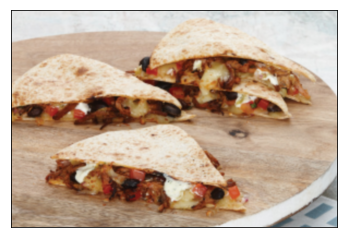

{'brand': 'pepsi', 'probability': 0.0007631243206560612}


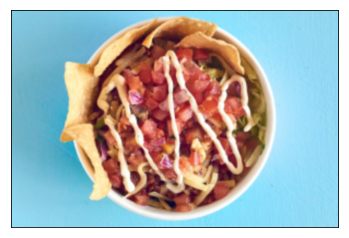

{'brand': 'coca-cola', 'probability': 0.16808778047561646}


In [3]:
def show_img():
    for i in meal_img['s3key'][220:260:2]:
        result= predict_cocacola(i)
        print(result) 
    
show_img()  